# Pairwise State-Merger Analysis

This notebook implements the pairwise state-merger analysis from **"Algorithm Development in Neural Networks: Insights from the Streaming Parity Task"**

### Goal:
Reproduce Figure 7 by analyzing which prefix pairs that "agree" on future continuations have their hidden states merge during training.

### Key Concepts
- **Agreeing prefixes**: Two prefixes that lead to the same parity for all possible continuations
- **State merger**: When two hidden states become similar (distance < ε)
- **Threshold behavior**: The paper predicts a threshold at min(m₁,m₂) ≈ 3

### 1. Setup and Imports

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence, pack_sequence
import pandas as pd
import os
from pathlib import Path
from datetime import datetime


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from models.parity_rnn import ParityRNN
from state_merge_analysis import StateMergerAnalyzer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### 2. Load Your Trained Model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParityRNN(input_size=2, hidden_size=100, output_size=2).to(device)
checkpoint = torch.load('../models/checkpoints/parity_rnn_checkpoint.pt', map_location=device)
model.load_state_dict(checkpoint["model_state"])
model.eval()

/var/folders/4z/s244bv2s5f7g8mctfr_jt3sc0000gn/T/ipykernel_37093/1250009842.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../models/checkpoint

ParityRNN(
  (rnn): RNN(2, 100, batch_first=True)
  (readout): Linear(in_features=100, out_features=2, bias=True)
)

### 3. Heatmap & Plotting Functions

In [3]:

def create_heatmap_data(L_train, merge_fractions):
    """Create 2D array for heatmap plotting"""
    heatmap = np.zeros((8, 8), dtype=np.float64)
    
    filled = 0
    for (m1, m2), data in merge_fractions.items():
        if isinstance(data, dict) and 'fraction' in data:
            fraction = float(data['fraction'])
            if 1 <= m1 <= L_train and 1 <= m2 <= L_train:
                heatmap[m1-1, m2-1] = fraction
                heatmap[m2-1, m1-1] = fraction
                filled += 1
    
    print(f"✅ Created heatmap: shape={heatmap.shape}, filled={filled} pairs")
    print(f"   Value range: {heatmap.min():.3f} to {heatmap.max():.3f}")
    
    return heatmap


In [4]:
def plot_merger_heatmap(L_train, heatmap_data, save_path=None):
    """Plot the merger heatmap to reproduce Figure 7."""
    plt.figure(figsize=(10, 8))

    ax = plt.gca()
    im = ax.imshow(heatmap_data, cmap='viridis', aspect='equal',
               vmin=0, vmax=0.13, origin='lower')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Merge Fraction', rotation=270,
                       labelpad=20, fontsize=12)

    plt.xlabel('Prefix Length m₂', fontsize=12)
    plt.ylabel('Prefix Length m₁', fontsize=12)
    plt.title('Pairwise State-Merger Analysis\n(Reproducing Figure 7)',
                  fontsize=14, pad=20)

    ticks = list(range(0, L_train, 2))
    tick_labels = [str(i + 1) for i in ticks]
    plt.xticks(ticks, tick_labels)
    plt.yticks(ticks, tick_labels)

    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if not np.isnan(heatmap_data[i, j]):
                value = heatmap_data[i, j]
                color = 'white' if value > 0.5 else 'black'
                plt.text(j, i, f'{value:.2f}', ha='center', va='center',
                             color=color, fontsize=8, weight='bold')

    plt.plot([0, L_train - 1], [0, L_train - 1],
             'r--', alpha=0.7, linewidth=2, label='m₁ = m₂')

    threshold_line = 2.5 
    plt.axhline(y=threshold_line, color='red',
                    linestyle=':', alpha=0.8, linewidth=2)
    plt.axvline(x=threshold_line, color='red',
                    linestyle=':', alpha=0.8, linewidth=2)

    plt.text(threshold_line + 0.5, L_train - 1, 'Threshold\n≈ 3',
                 ha='left', va='top', color='red', fontsize=10, weight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved heatmap to {save_path}")

    plt.show()

### 4. Save Analysis to CSV

In [5]:
def save_analysis_to_csv(analyzer, max_continuation_length):
    """Save all analysis data to CSV files"""
    
    analysis_dir = Path("../models/analysis")
    analysis_dir.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = f"merger_analysis_L{analyzer.L_train}_eps{analyzer.epsilon}_cont{max_continuation_length}_{timestamp}"
    
    saved_files = []
    
    try:
        if hasattr(analyzer, 'merge_fractions') and analyzer.merge_fractions:
            merge_fractions_data = []
            for (m1, m2), data in analyzer.merge_fractions.items():
                if isinstance(data, dict):
                    row = {
                        'm1': m1,
                        'm2': m2,
                        'merge_fraction': data.get('fraction', data.get('merge_fraction', 0)),
                        'total_pairs': data.get('total', data.get('total_pairs', 0)),
                        'merged_pairs': data.get('merged', data.get('merged_pairs', 0))
                    }
                else:
                    row = {
                        'm1': m1,
                        'm2': m2,
                        'merge_fraction': data,
                        'total_pairs': 'unknown',
                        'merged_pairs': 'unknown'
                    }
                merge_fractions_data.append(row)
            
            df_fractions = pd.DataFrame(merge_fractions_data)
            fractions_file = analysis_dir / f"{base_name}_merge_fractions.csv"
            df_fractions.to_csv(fractions_file, index=False)
            saved_files.append(fractions_file)
            print(f"✅ Merge fractions saved: {fractions_file.name}")
        
        if hasattr(analyzer, 'heatmap_data') and analyzer.heatmap_data is not None:
            heatmap_file = analysis_dir / f"{base_name}_heatmap.csv"
            np.savetxt(heatmap_file, analyzer.heatmap_data, delimiter=',', fmt='%.6f')
            saved_files.append(heatmap_file)
            print(f"✅ Heatmap data saved: {heatmap_file.name}")
        
        if hasattr(analyzer, 'merge_data') and analyzer.merge_data:
            merge_data_summary = []
            for (m1, m2), pairs_list in analyzer.merge_data.items():
                for pair_data in pairs_list:
                    row = {
                        'm1': m1,
                        'm2': m2,
                        'prefix1': str(pair_data.get('prefix1', '')),
                        'prefix2': str(pair_data.get('prefix2', '')),
                        'merged': pair_data.get('merged', False),
                        'distance': pair_data.get('distance', 'unknown'),
                        'agrees_on_continuations': pair_data.get('agrees', True)
                    }
                    merge_data_summary.append(row)
            
            df_merge_data = pd.DataFrame(merge_data_summary)
            merge_data_file = analysis_dir / f"{base_name}_detailed_pairs.csv"
            df_merge_data.to_csv(merge_data_file, index=False)
            saved_files.append(merge_data_file)
            print(f"✅ Detailed pairs data saved: {merge_data_file.name}")
        
        metadata = {
            'timestamp': timestamp,
            'L_train': analyzer.L_train,
            'epsilon': analyzer.epsilon,
            'max_continuation_length': max_continuation_length,
            'total_agreeing_pairs': sum(len(lst) for lst in analyzer.merge_data.values()) if hasattr(analyzer, 'merge_data') else 0,
            'total_merged_pairs': sum(sum(1 for d in lst if d.get('merged', False)) for lst in analyzer.merge_data.values()) if hasattr(analyzer, 'merge_data') else 0,
            'unique_length_pairs': len(analyzer.merge_fractions) if hasattr(analyzer, 'merge_fractions') else 0,
            'files_saved': [f.name for f in saved_files]
        }
        
        metadata_file = analysis_dir / f"{base_name}_metadata.csv"
        df_metadata = pd.DataFrame([metadata])
        df_metadata.to_csv(metadata_file, index=False)
        saved_files.append(metadata_file)
        print(f"✅ Metadata saved: {metadata_file.name}")
        
        print(f"\n📁 All analysis data saved to: {analysis_dir}")
        print(f"📋 Total files created: {len(saved_files)}")
        
        return saved_files
        
    except Exception as e:
        print(f"❌ Error saving analysis data: {e}")
        import traceback
        traceback.print_exc()
        return saved_files

### 5. Run the Pairwise State-Merger Analysis

In [6]:
def run_state_merger_analysis(analyzer, max_continuation_length: int = 3):
    print("\n" + "=" * 60)
    print("PAIRWISE STATE-MERGER ANALYSIS")
    print("Reproducing Figure 7 from van Rossem & Saxe (2025)")
    print("=" * 60)
    
    merge_data, merge_fractions = analyzer.analyze_state_mergers(max_continuation_length)
    
    if merge_data is None:
        print("❌ Analysis failed - no agreeing pairs found")
        return None
    
    print("\n=== PLOTTING RESULTS ===")
    save_path = "../figures/figure_7"
    heatmap_data = create_heatmap_data(analyzer.L_train, merge_fractions)
    plot_merger_heatmap(analyzer.L_train, heatmap_data, save_path=save_path) 
    
    # Summary
    total_agreeing_pairs = sum(len(lst) for lst in merge_data.values())
    total_merged_pairs = sum(sum(1 for d in lst if d['merged'])
                             for lst in merge_data.values())
    overall_merge_rate = (total_merged_pairs / total_agreeing_pairs
                          if total_agreeing_pairs > 0 else 0)
    
    print("\n=== SUMMARY ===")
    print(f"Total agreeing prefix pairs: {total_agreeing_pairs}")
    print(f"Total merged pairs: {total_merged_pairs}")
    print(f"Overall merge rate: {overall_merge_rate:.3f}")
    print(f"Distance threshold (ε): {analyzer.epsilon}")
    
    analyzer.merge_data = merge_data
    analyzer.heatmap_data = heatmap_data
    analyzer.merge_fractions = merge_fractions
    analyzer.threshold_data = None

    print("\n=== SAVING TO CSV ===")
    saved_files = save_analysis_to_csv(analyzer, max_continuation_length)
    
    return analyzer

Configuration parameters

In [7]:
L_TRAIN = 10                    # Maximum training sequence length
EPSILON = 0.25                  # Distance threshold for merged states
MAX_CONTINUATION_LENGTH = 8     # How far to look ahead for agreements

print("Analysis Configuration:")
print(f"  L_train: {L_TRAIN}")
print(f"  Distance threshold (ε): {EPSILON}")
print(f"  Max continuation length: {MAX_CONTINUATION_LENGTH}")
print(f"\nNote: This analysis can be computationally expensive!")
print(f"      For L_train=10: ~{2**10} prefixes, ~{(2**10)**2//2:,} pairs to check")

Analysis Configuration:
  L_train: 10
  Distance threshold (ε): 0.25
  Max continuation length: 8

Note: This analysis can be computationally expensive!
      For L_train=10: ~1024 prefixes, ~524,288 pairs to check



PAIRWISE STATE-MERGER ANALYSIS
Reproducing Figure 7 from van Rossem & Saxe (2025)
📁 Loading cached results from: cache/state_merger/merger_analysis_16138527.pkl
✅ Cache loaded successfully!
   - Cached parameters: {'L_train': 10, 'epsilon': 0.25, 'max_continuation_length': 8, 'model_params': 10602}
   - Found 35 unique prefix pairs

=== PLOTTING RESULTS ===
✅ Created heatmap: shape=(8, 8), filled=35 pairs
   Value range: 0.000 to 0.125


/var/folders/4z/s244bv2s5f7g8mctfr_jt3sc0000gn/T/ipykernel_37093/345951758.py:45: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/4z/s244bv2s5f7g8mctfr_jt3sc0000gn/T/ipykernel_37093/345951758.py:45: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/4z/s244bv2s5f7g8mctfr_jt3sc0000gn/T/ipykernel_37093/345951758.py:48: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/var/folders/4z/s244bv2s5f7g8mctfr_jt3sc0000gn/T/ipykernel_37093/345951758.py:48: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved heatmap to ../figures/figure_7


/Users/ignazioperez/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ignazioperez/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


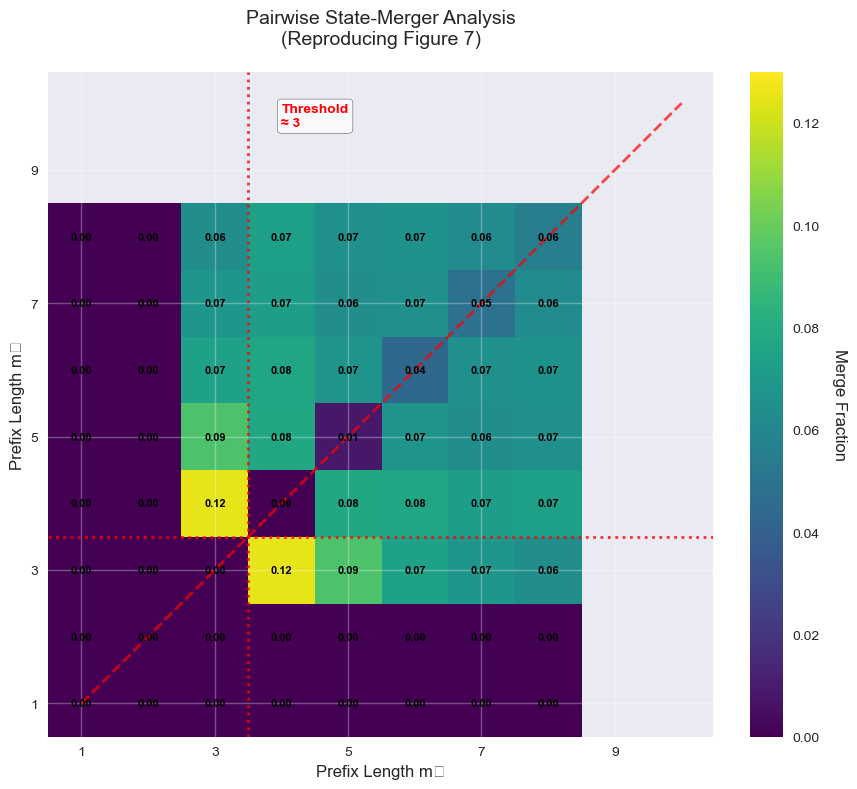


=== SUMMARY ===
Total agreeing prefix pairs: 64770
Total merged pairs: 3873
Overall merge rate: 0.060
Distance threshold (ε): 0.25

=== SAVING TO CSV ===
✅ Merge fractions saved: merger_analysis_L10_eps0.25_cont8_20250725_020415_merge_fractions.csv
✅ Heatmap data saved: merger_analysis_L10_eps0.25_cont8_20250725_020415_heatmap.csv
✅ Detailed pairs data saved: merger_analysis_L10_eps0.25_cont8_20250725_020415_detailed_pairs.csv
✅ Metadata saved: merger_analysis_L10_eps0.25_cont8_20250725_020415_metadata.csv

📁 All analysis data saved to: ../models/analysis
📋 Total files created: 4

Analysis Complete!


In [8]:
analyzer = StateMergerAnalyzer(model, device, L_TRAIN, EPSILON)
run_state_merger_analysis(analyzer, MAX_CONTINUATION_LENGTH)

print("\nAnalysis Complete!")